# Shcok Analysis

A scenario can be implemented in multiple ways within mario. 

## Shock implementation using python script


In this approach, you need to use the pandas functions properly to implement changes in your database, and update the matrices in mario scenario accordingly. Lets load the test example to see how it works.

In [1]:
from mario import load_test,slicer

In [2]:
test = load_test("IOT")

Let's assume you want to model a final demand increase scenario in your database. The first step would be to clone a new scneario from baseline data:

In [3]:
test.clone_scenario(
    scenario='baseline', # from which scenario clone  
    name='Final demand increase',# what will be the name of the new scenario
)

print(test.scenarios)

['baseline', 'Final demand increase']


Now lets assume you want to increase the local final demand of agriculture sectors in Italy by 10%. This is how the matrix of final demand (Y) looks like:

In [4]:
test.Y

Region                                     Italy                  RoW
Level                       Consumption category Consumption category
Item                                Final Demand         Final Demand
Region Level  Item                                                   
Italy  Sector Agriculture           2.843471e+04         4.875449e+03
              Construction          1.447732e+05         4.655076e+02
              Manufacturing         2.998989e+05         2.316510e+05
              Mining                9.219922e+02         2.023559e+02
              Services              1.052847e+06         5.080214e+04
              Transport             5.738525e+04         5.686902e+03
RoW    Sector Agriculture           1.099317e+04         2.073065e+06
              Construction          1.072044e+03         1.059925e+07
              Manufacturing         1.217507e+05         1.816087e+07
              Mining                4.621724e+02         4.603934e+05
              Services              4.307168e+04         4.842609e+07
              Transport             8.726021e+03         3.100367e+06

So you need to slice the database properly to increase the total final demand of agriculture sector in Italy. For easier use, you can use mario slicer function in case you dont want to deal with slicing of pandas through loc function:

In [5]:
Y_rows = slicer(matrix='Y',axis= 0,Region=['Italy'],Item=['Agriculture'])
Y_cols = slicer(matrix='Y',axis= 1,Region=['Italy'],Item=['Final Demand'])

Now you can increase the specific value by 10% as:

In [6]:
Y_new = test.query(
    matrices = "Y",
    scenarios="Final demand increase"
    )

In [7]:
Y_new.loc[Y_rows,Y_cols] *= 1.1

In [8]:
print("Baseline Y",test.Y.loc[Y_rows,Y_cols])
print("Scenario Y",Y_new.loc[Y_rows,Y_cols])

Baseline Y Region                                   Italy
Level                     Consumption category
Item                              Final Demand
Region Level  Item                            
Italy  Sector Agriculture         28434.707841
Scenario Y Region                                   Italy
Level                     Consumption category
Item                              Final Demand
Region Level  Item                            
Italy  Sector Agriculture         31278.178625


Now you need to update the scenario data then reset all the matrices of scenario to coefficients only (as they are not changed!), to recaulcuate the matrices again.

In [9]:
test.update_scenarios(scenario='Final demand increase',Y=Y_new)
test.reset_to_coefficients(scenario='Final demand increase')


Lets take a look to a graph to see how things look like:

In [10]:
# Change in total production
delta_X = test.query(
    matrices = "X", # which matrix
    scenarios = "Final demand increase", # take the new scenario
    base_scenario="baseline", # take the base scenario
    type = "absolute" # calcualte the absolute changes
)

In [11]:
delta_X

production
Region Level  Item                      
Italy  Sector Agriculture    2961.338965
              Construction     57.329630
              Manufacturing   597.267115
              Mining            6.332699
              Services        745.379267
              Transport       185.686254
RoW    Sector Agriculture     121.156060
              Construction      5.421589
              Manufacturing   302.857308
              Mining           45.949173
              Services        193.241123
              Transport        36.432992

<Axes: xlabel='Region,Level,Item'>

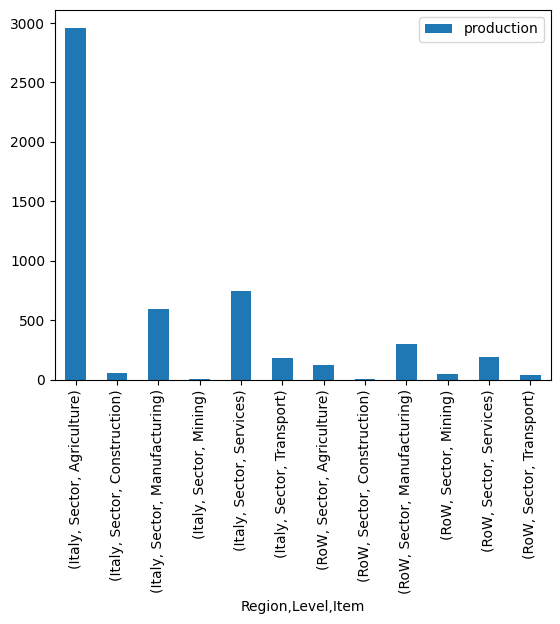

In [12]:
delta_X.plot(kind="bar")

## Implementing a shock using mario excel platform

mario also supports introduction of very complex shocks through an excel platform, which can be generated with mario automatically based on the shape of the database. Then scenarios can be translated with the options of the excel files.

The excel platform alos gives the opprotunity to define cluseters of sets like Region, Secotr,.... to implement more complex shocks.

Lets implement a different shock, by first loading a fresh test example.

In [13]:
test = load_test("IOT")

You can ask mario to generate an excel file where you can fill your shocks!

In [14]:
save_path = "shock_iot.xlsx"
test.get_shock_excel(path=save_path)

An excel file will be created in the given path. The excel file has 6 different pages as follow:

1. indeces: this page contains all the valid data that can be used for the definition of the shocks. These values are used to validate the data on other sheets
2. main: This sheet is an optional sheet that user may use for the intermediate calculations and defining the assumptions of the problem
3. Y: This sheet is specified for implementing a shock on the Final demand
4. v: This sheet is specified for implementing a shock on tha value added
5. e: This sheet is specified for implementing a shock on the satellite account
6. z: This sheet is specified for implementing a shock on the intersectoral transaction matrix

In this version of mario, there are different ways to implement a shock (more options will be added to the next versions):

1. update: this method updates a value on the coefficient matrix
2. Absolute: this method implements the change in terms of absolute values (flows) and implement the change on coefficient matrix
3. Percentage: this method implements a percentage change directly on coefficient matrix (the values should be between 0 to 1 meaning that 10% increase is 0.1 and 10% decrease is -0.1)

For example, a scenario with 10% increase in the self consumption of services sector in Italy can be modeled in the excel file as follow:

![Alt text](shock_z.png)


Let's assume that we fill the excel file, and call it shock_iot_filled.xlsx. To implement the shock, you can:

In [15]:
test.shock_calc(
    io=r'shock_iot_filled.xlsx', # Path to the excel file
    z= True, # the shock will be implemented on z
    notes=['you may add some notes for metadata']
)

In [16]:
test.scenarios

['baseline', 'shock 1']

If you dont choose a name for your shock, mario will do it for you!

### Defining the Clusters
In order to impelemnt shocks on a bunch of items, you can use clusters. Lets implement a change in the local final demand of all sectors in italy for 10%, first without the clusters.

In this way, user needs to replicate the same change for all the sectros in italy as shown in the picture

![Alt text](no_cluster.png)


n easier way to this shock is to use clusters. In this case user needs to define a cluster on the 'Sector'. But clusters can be defined on all the sets of the table (for checking all the sets of table you can use test.sets)

A cluster on sectors can be defined as follow:

In [17]:
clusters = {'Sector': # Cluster on which set
                    {'All': test.get_index('Sector')    # what is the name of the cluster and what it contains
                    }
           }

So in this case, we are making a cluster on Sector. The cluster will be called All and it contains all the Sectors in the database. Now if we request mario to generate the shock excel, 'All' is added as a valid option for the Sector.

In [18]:
save_path = 'shock_iot_cluster.xlsx'
test.get_shock_excel(path=save_path,**clusters)

The same shock now can be implemented as the shown in the pic:

![Alt text](cluster.png)

In order to implement a shock, we need to use the excel files and the definition of clusters as follow. Let's assume we call the filled excel file as shock_iot_cluster_filled.xlsx:

In [19]:
test.shock_calc(
    io=r'shock_iot_cluster_filled.xlsx', # Path to the excel file
    Y= True, # the shock will be implemented on Y
    **clusters
)

In [20]:
test.scenarios

['baseline', 'shock 1', 'shock 2']

Just to understand what is happening behind the scene, you can take a look to the metadata history:

In [21]:
test.meta_history

[2024-06-26 18:54:48]    Table added into metadata with value equal to IOT.
[2024-06-26 18:54:48]    Price added into metadata with value equal to None.
[2024-06-26 18:54:48]    Source added into metadata with value equal to None.
[2024-06-26 18:54:48]    Year added into metadata with value equal to None.
[2024-06-26 18:54:48]    Shocks implemented from shock_iot_filled.xlsx as follow:
[2024-06-26 18:54:48]    Shock (Notes): you may add some notes for metadata
[2024-06-26 18:54:48]    Shock on z implemented: row_region_:Italy, row_level_:Sector, row_sector_:Services, column_region_:Italy, column_level_:Sector column_sector_:Services, type: Percentage, value: 0.1.
[2024-06-26 18:54:48]    Shocks implemented from shock_iot_cluster_filled.xlsx as follow:
[2024-06-26 18:54:48]    Shock on Y implemented: row_region:Italy, row_level:Sector, row_sector:['Agriculture', 'Mining', 'Manufacturing', 'Services', 'Construction', 'Transport'], column_region:Italy, demand_category: Final Demand, type: